In [1]:
import numpy as np
import fixed_income_derivatives as fid
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

In [2]:
r0, a, b, sigma = 0.02, 0.6, 0.03, 0.02
T_max = 10
alpha = 0.5
M = int(T_max/alpha) + 1
T = np.array([i*alpha for i in range(0,M)])
p = fid.zcb_price_vasicek(r0,a,b,sigma,T)
R = fid.spot_rate_vasicek(r0,a,b,sigma,T)
f = fid.forward_rate_vasicek(r0,a,b,sigma,T)
f_6m = fid.zcb_to_forward_rates(T,p,horizon = 1)

### b) Fitting a Vasicek model to data

In [3]:
param_0 = 0.03, 0.5, 0.04, 0.04
result = minimize(fid.fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")

param_0 = 0.03, 0.5, 0.04
result = minimize(fid.fit_vasicek_no_sigma_obj,param_0,method = 'nelder-mead',args = (sigma,R,T),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit without sigma: {result.x}. SE of the fit: {result.fun}")

Parameters from the fit: [0.0190537  0.6        0.0318926  0.05168286]. SSE of the fit: 1.9740781929969167e-33
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 238
         Function evaluations: 448
Parameters from the fit without sigma: [0.02 0.6  0.03]. SE of the fit: 3.6111186457260672e-34


/var/folders/nd/4k3_lp8n50j_h8d9rbthfry80000gn/T/ipykernel_9029/2987481509.py:2: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-20,'disp': True})


## c) Swap rate or forward swap rate

In [4]:
idx_n, idx_N = 0, 20
S_swap = 0
for idx in range(idx_n+1,idx_N+1):
    S_swap += alpha*p[idx]
R_swap = (p[idx_n] - p[idx_N])/S_swap
print(f"Par swap rate: {R_swap}")

Par swap rate: 0.04433512150682563


### Plotting the spot par swap rate:

In [5]:
def swap_fct(idx_n,idx_N,alpha,p):
    S_swap = 0
    for idx in range(idx_n+1,idx_N+1):
        S_swap += alpha*p[idx]
    R_swap = (p[idx_n] - p[idx_N])/S_swap
    return R_swap, S_swap

R_swap_plot = np.zeros([M])
S_swap_plot = np.zeros([M])
idx_N_plot = np.array([i for i in range(1,M)])
for idx in idx_N_plot:
    R_swap_plot[idx], S_swap_plot[idx] = swap_fct(0,idx,alpha,p)[0], swap_fct(0,idx,alpha,p)[1]

### d) Caplet and cap prices

In [6]:
strike = 0.05
idx_cap_begin, idx_cap_end = 2, M
price_caplet = np.zeros([M])
for i in range(2,M):
    price_caplet[i] = (1 + alpha*strike)*fid.euro_option_price_vasicek(1/(1 + alpha*strike),T[i-1],T[i],p[i-1],p[i],a,sigma,type = "put")
price_cap = sum(price_caplet[idx_cap_begin:idx_cap_end])
premium = alpha*(price_cap/S_swap)
print(f"Caplet prices: {10000*price_caplet}")
print(f"Cap price: {10000*price_cap}, cap premium: {10000*premium}")

def price_cap_fct(sigma,strike,S_swap,idx_cap_begin,idx_cap_end,M,alpha,T,a):
    p = fid.zcb_price_vasicek(r0,a,b,sigma,T)
    price_caplet = np.zeros([M])
    for i in range(2,M):
        price_caplet[i] = (1 + alpha*strike)*fid.euro_option_price_vasicek(1/(1 + alpha*strike),T[i-1],T[i],p[i-1],p[i],a,sigma,type = "put")
    price_cap = sum(price_caplet[idx_cap_begin:idx_cap_end])
    premium = alpha*(price_cap/S_swap)
    return price_cap, premium

price_cap_bump = price_cap_fct(sigma+0.001,strike,S_swap,idx_cap_begin,idx_cap_end,M,alpha,T,a)
print(f"price_cab after bump: {price_cap_bump[0]}, difference: {10000*(price_cap-price_cap_bump[0])}")

Caplet prices: [ 0.          0.          0.82727383  4.92962125  9.78459279 14.003043
 17.28465884 19.6804256  21.33830596 22.41599481 23.05217838 23.35958339
 23.42612138 23.31867153 23.08729692 22.76905597 22.39115737 21.97345193
 21.53034602 21.07224436 20.60662489]
Cap price: 356.85064818963457, cap premium: 21.986708297323425
price_cab after bump: 0.037698999085514336, difference: -20.139342665508806


### Simulating the short rate in the Vasicek model

In [7]:
np.random.seed(13)
M_simul, T_simul = 1000, 10
size_ci = 0.95
r_simul = fid.short_rate_simul(r0,(a,b,sigma),M_simul,T_simul,method = "vasicek")
t_simul = np.array([i*(T_simul/M_simul) for i in range(0,M_simul+1)])
lb, ub = fid.ci_vasicek(r0,a,b,sigma,t_simul,size_ci)
mu_sd, sigma_sd = b/a, sigma/(np.sqrt(2*a))
lb_sd = mu_sd - norm.ppf(size_ci + 0.5*(1-size_ci))*sigma_sd
ub_sd = mu_sd + norm.ppf(size_ci + 0.5*(1-size_ci))*sigma_sd

### f) Computing the price of a 2Y8Y swaption

In [8]:
idx_n_swaption, idx_N_swaption = 4, 20
M_simul_swaption, N_simul, T_simul_swaption = 400, 5000, T[idx_n_swaption]
chi, price_swaption_simul, price_swaption_plot = np.zeros([N_simul]), np.zeros([N_simul]), np.zeros([N_simul])
T_swaption = np.array([T[i] - T[idx_n_swaption] for i in range(idx_n_swaption,idx_N_swaption+1)])
R_swaption = 0.045
for i in range(0,N_simul):
    r_simul_swaption = fid.short_rate_simul(r0,(a,b,sigma),M_simul_swaption,T_simul_swaption,method = "vasicek")
    p_swaption = fid.zcb_price_vasicek(r_simul_swaption[-1],a,b,sigma,T_swaption)
    R_swap, S_swap = swap_fct(0,idx_N_swaption-idx_n_swaption,alpha,p_swaption)
    chi[i] = max(R_swap-R_swaption,0)*S_swap
    price_swaption_simul[i] = np.exp(-(T_simul_swaption/M_simul_swaption)*sum(r_simul_swaption))*chi[i]
    price_swaption_plot[i] = sum(price_swaption_simul[0:i+1])/(i+1)
price_swaption = sum(price_swaption_simul)/N_simul
print(f"price_swaption: {price_swaption}")

price_swaption: 0.021590820226600364


### Ploot of zcb prices, spot rates and instantaneous forward rates in the Vasicek model


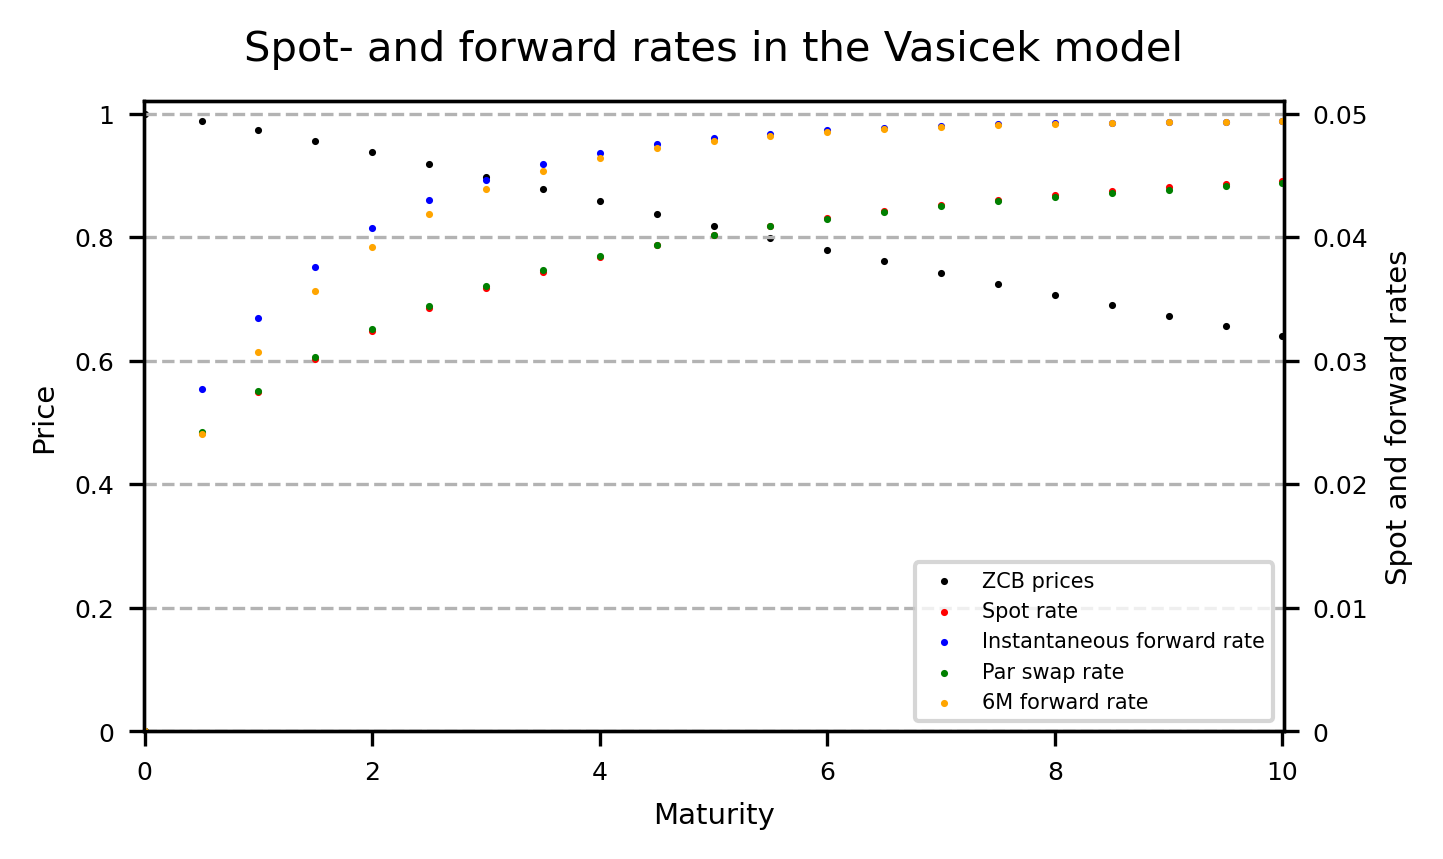

In [9]:
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Spot- and forward rates in the Vasicek model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Maturity",fontsize = 7)
yticks1 = [0,0.2,0.4,0.6,0.8,1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Price",fontsize = 7)
p1 = ax.scatter(T, p, s = 2, color = 'black', marker = ".",label="ZCB prices")
ax2 = ax.twinx()
yticks2 = [0,0.01,0.02,0.03,0.04,0.05]
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2,fontsize = 6)
ax2.set_ylim([yticks2[0],yticks2[-1]+(yticks2[-1]-yticks2[0])*0.02])
ax2.set_ylabel(f"Spot and forward rates",fontsize = 7)
p2 = ax2.scatter(T, R, s = 2, color = 'red', marker = ".",label="Spot rate")
p3 = ax2.scatter(T, f, s = 2, color = 'blue', marker = ".",label="Instantaneous forward rate")
p4 = ax2.scatter(T, R_swap_plot, s = 2, color = 'green', marker = ".",label="Par swap rate")
p5 = ax2.scatter(T, f_6m, s = 2, color = 'orange', marker = ".",label="6M forward rate")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 5)
# fig.savefig("C:/")
plt.show()

### Plotting of simulated short rates in the Vasicek model


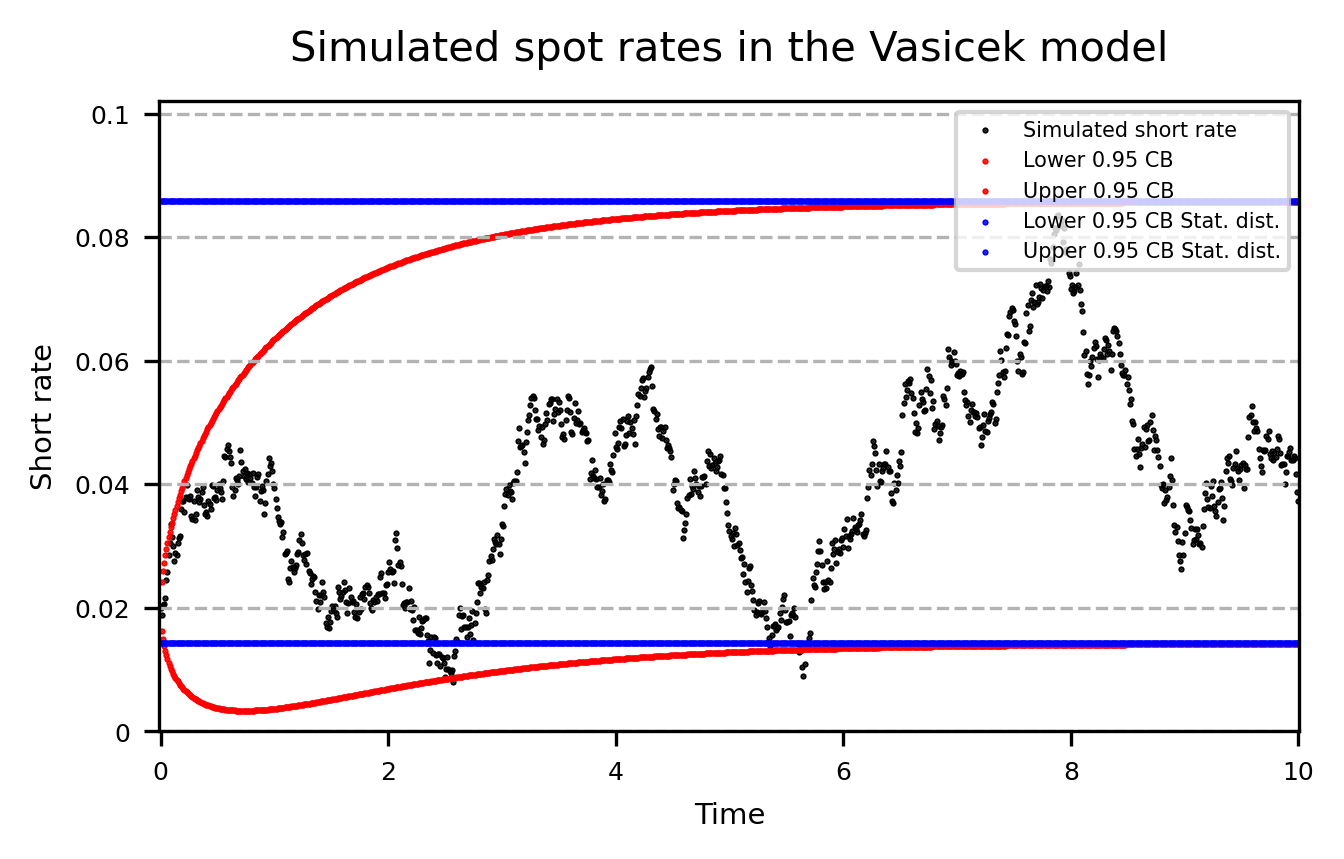

In [10]:
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated spot rates in the Vasicek model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul, r_simul, s = 1, color = 'black', marker = ".",label="Simulated short rate")
p2 = ax.scatter(t_simul, lb, s = 1, color = 'red', marker = ".",label=f"Lower {size_ci} CB")
p3 = ax.scatter(t_simul, ub, s = 1, color = 'red', marker = ".",label=f"Upper {size_ci} CB")
p4 = ax.scatter(t_simul, lb_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Lower {size_ci} CB Stat. dist.")
p5 = ax.scatter(t_simul, ub_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Upper {size_ci} CB Stat. dist.")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
# fig.savefig("C:/")
plt.show()

### Plot of option prices as a function of N_simul

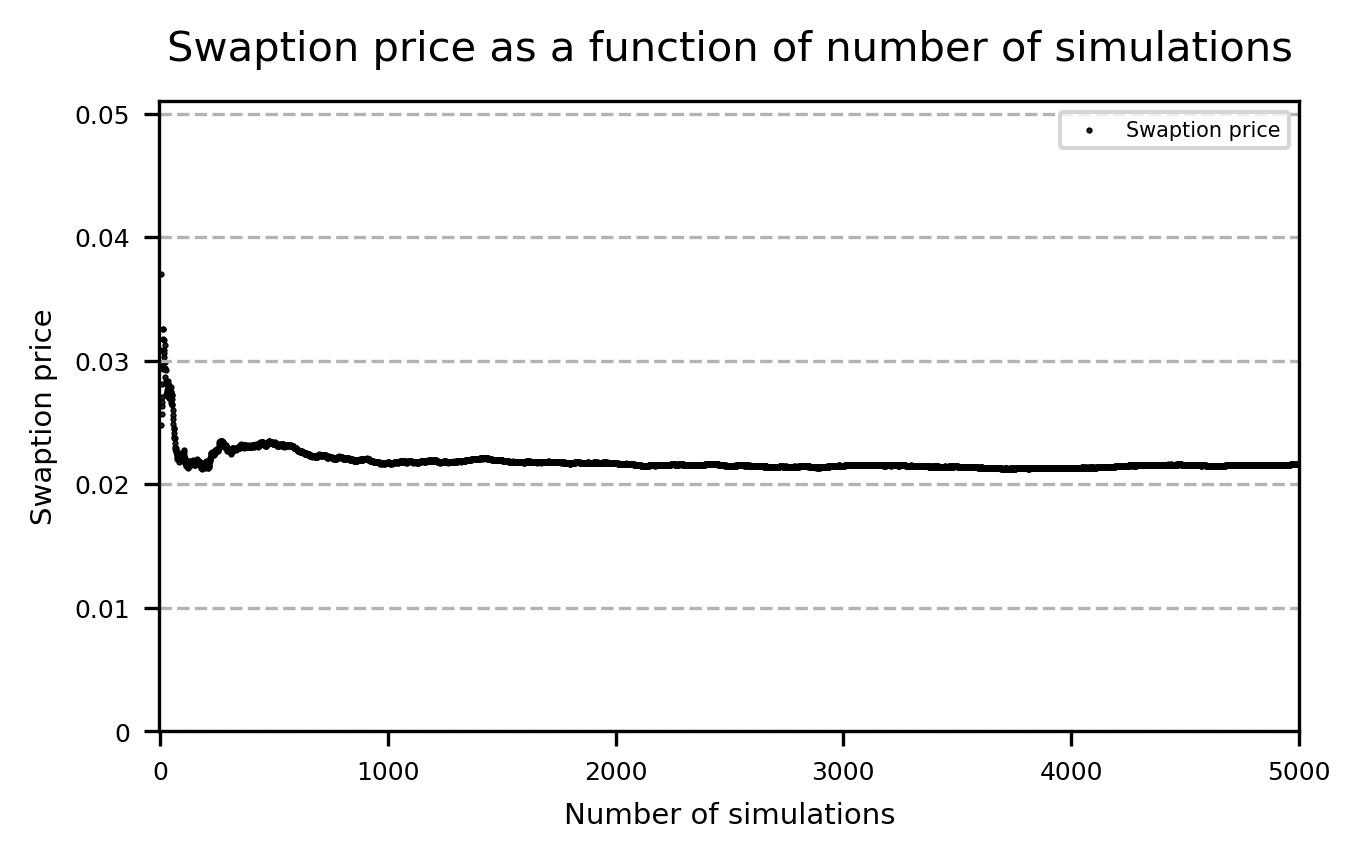

In [11]:
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Swaption price as a function of number of simulations",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,int((1/5)*N_simul),int((2/5)*N_simul),int((3/5)*N_simul),int((4/5)*N_simul),int(N_simul)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-2,xticks[-1]+2])
plt.xlabel(f"Number of simulations",fontsize = 7)
yticks1 = [0,0.01,0.02,0.03,0.04,0.05]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Swaption price",fontsize = 7)
p1 = ax.scatter([i for i in range(1,N_simul+1)], price_swaption_plot, s = 1, color = 'black', marker = ".",label="Swaption price")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
# fig.savefig("C:/")
plt.show()